In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

df_t = pd.read_csv('QandA.csv')

# Tokenizer
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Stemmer
from nltk.stem.porter import PorterStemmer

porter_stemmer = PorterStemmer()
def stem_words(word_list):
    '''
    Stem words
    
    Input:
    -----------------------
    List of words
    
    Return:
    ------------------------
    List of stemmed words
    '''
    return [porter_stemmer.stem(words) for words in word_list]

# lemmatizer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize_words(word_list):
    '''
    Lemmatize words
    
    Input:
    -----------------------
    List of words
    
    Return:
    ------------------------
    List of lemmatized words
    '''
    return [wordnet_lemmatizer.lemmatize(words) for words in word_list]

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hello', 'hi', 'welcom', 'headout', 'know', 'experi', 'refer', 'help', 'ani', 'chat', 'problem', 'may', 'reach', 'need', 'let', 'u', 'feel', 'free', 'contact', 'realli', 'appreci', 'could', 'rate', 'chat', 'thank', 'today', 'wa', 'nice', 'talk', 'great', 'day', 'goodby', 'would', 'like','plea', 'wait', 'minut', 'check', 'thi', 'anyth', 'el', 'step', 'away', 'assist', 'custom', 'bye', 'hey', 'ok','get', 'ye', 'safari', 'khalifa', 'burj', 'aquarium', 'roman', 'palatin', 'vatican', 'dubai'])
def remove_stopwords(word_list, stop_words):
    '''
    Remove stop words
    
    Input:
    -----------------------
    List of words
    
    Return:
    ------------------------
    List of words with stop words removed
    '''
    return [word for word in word_list if word not in stop_words]

# Combine all
def preprocess(text):
    return remove_stopwords(lemmatize_words(stem_words(tokenizer.tokenize(text.lower()))), stop_words)
preprocess('I will be stepping away get to assist notastopword other customers now, bye! :)')

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


['notastopword']

In [2]:
# Preprocess transcripts
df_l = df_t.QandA.apply(lambda s: ' '.join(preprocess(s)))

# Anchored CorEx modeling

In [3]:
from corextopic import corextopic as ct
# Build vocabulary list for CorEx topic model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=20000, binary=True)
# Corpus
corpus = cv.fit_transform(df_l)
# Vocabulary
words = list(np.asarray(cv.get_feature_names()))

# Anchor Words for Anchored CorEx
anchor_words = [['cashback', 'cash'], 
                ['refund', 'cancel'], 
                ['child', 'adult','year','old','age','kid'], 
                ['seat', 'choos','select','section','offic','exact','togeth'],
                ['discount','coupon','code','offer'],
                ['card','payment','work','complet','error','issu','differ','tri'],
                ['pm','morn','night']
               ]

# Build model
ntopic = 25
topic_model = ct.Corex(n_hidden=ntopic, max_iter=200, seed=100)
topic_model.fit(corpus, words=words, anchors=anchor_words, anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: cashback,cash,wallet,log,facebook,user,creat,futur,virtual,account
1: cancel,refund,polici,strict,reschedul,di,amend,non,money,sono
2: adult,child,year,old,age,kid,abov,yr,18,daughter
3: seat,select,choos,offic,section,exact,togeth,box,map,assign
4: offer,discount,code,coupon,promo,love,wow,appli,unfortun,promot
5: tri,card,differ,work,issu,payment,complet,error,credit,debit
6: pm,night,morn,00,30,10,wish,dure,departur,depart
7: com,http,www,unit,emir,gmail,link,variantid,support,write
8: ticket,buy,purchas,tower,eiffel,onlin,collect,sell,counter,broadway
9: guid,tour,museum,colosseum,access,chapel,sistin,forum,audio,rome
10: meet,versail,point,palac,host,track,pari,specif,outsid,voucher
11: good,pleasur,nope,abt,hv,43,ill,mate,merci,tx
12: cruis,combo,arab,world,pas,dinner,river,singapor,park,zoo
13: id,sagrada,familia,order,sent,send,mail,told,barcelona,proof
14: hotel,pick,peter,st,drop,basilica,la,dune,por,pickup
15: paid,request,intellig,york,best,new,king,lion,school,rock
16: 

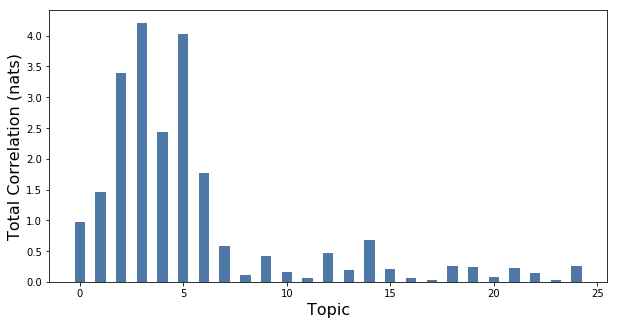

In [4]:
# Check Total Correlation for all topics
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

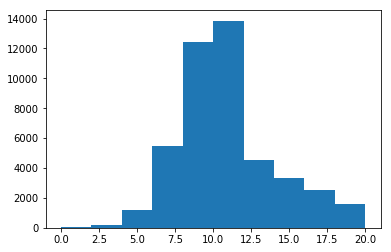

In [5]:
# Pointwise TC distribution
plt.hist(topic_model.log_z.sum(1), range=[0,20])
plt.show()

In [6]:
# Documents topic dataframe
df_top = pd.DataFrame(columns = ['logsum','topic','PTC'])
TC = topic_model.log_z
df_top['logsum'] = TC.sum(1)
df_top['topic'] = TC.argmax(1)
# Calculate Pointwise TC for each document
doc_cor = []
for i,row in df_top.iterrows():
    doc_cor.append(TC[i,int(row.topic)])
df_top['PTC'] = doc_cor
df_top.head()

,logsum,topic,PTC
0,58.927235,0,46.491126
1,48.682137,0,27.531751
2,6.146790,5,2.219499
3,22.803795,7,13.259783
4,16.555276,7,5.401563


In [7]:
# Percentage of each topic
df_perc = pd.DataFrame(columns=['topic_no','percentage','keywords'])
df_perc['topic_no'] = list(i for i in range(ntopic))
rowN = float(df_top.shape[0])
for i in range(ntopic):
#     Calculate percentage
    df_perc.at[i,'percentage'] = df_top.loc[(df_top.topic == i) & (df_top.PTC > 8)].shape[0]/rowN
#     Key words
    topic_words,_ = zip(*topics[i])
    df_perc.at[i,'keywords'] = ' ,'.join(topic_words)
    
df_perc.head(7)

,topic_no,percentage,keywords
0,0,0.0143095,"cashback ,cash ,wallet ,log ,facebook ,user ,c..."
1,1,0.0293442,"cancel ,refund ,polici ,strict ,reschedul ,di ..."
2,2,0.0447416,"adult ,child ,year ,old ,age ,kid ,abov ,yr ,1..."
3,3,0.0493805,"seat ,select ,choos ,offic ,section ,exact ,to..."
4,4,0.0526292,"offer ,discount ,code ,coupon ,promo ,love ,wo..."
5,5,0.0459202,"tri ,card ,differ ,work ,issu ,payment ,comple..."
6,6,0.0473557,"pm ,night ,morn ,00 ,30 ,10 ,wish ,dure ,depar..."


# Visualization

In [8]:
from scipy.optimize import curve_fit
from wordcloud import WordCloud

## Refund

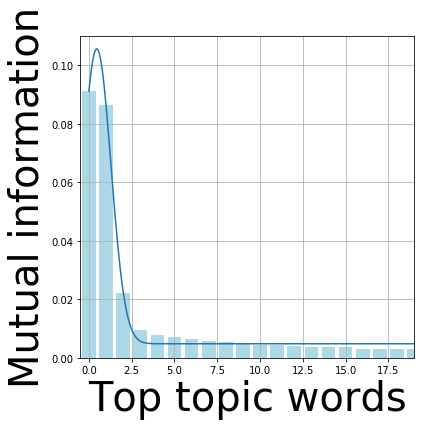

In [185]:
# Mutual information
nwords = 20
topic_words, proba = zip(*topic_model.get_topics(topic=1, n_words=nwords))
# Fitting
x = list(range(nwords))
fit = lambda x, A, x0, sigma, offset:  offset+A*np.exp(-((x-x0)/sigma)**2)
popt, pcov = curve_fit(fit, x, proba, p0=[1,0,1,0])


fig, ax = plt.subplots(figsize=(6,6))

ax.bar(x, proba, color="lightblue", zorder=0)

x = np.linspace(min(x),max(x),250)
ax.plot(x, fit(x,*popt))
ax.set_xlabel('Top topic words', fontsize=40)
ax.set_ylabel('Mutual information', fontsize=40)
ax.grid(True)
ax.axis([-.5,19,0,0.11])
plt.tight_layout()
plt.savefig('MIrefund.png')
plt.show()

In [40]:
# Word cloud
text = ' '.join(df_l.loc[(df_top.topic == 1) & (df_top.PTC > 8)].values)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

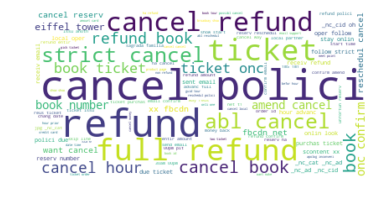

In [47]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('refund1.png', dpi=100)
plt.show()

## Kids

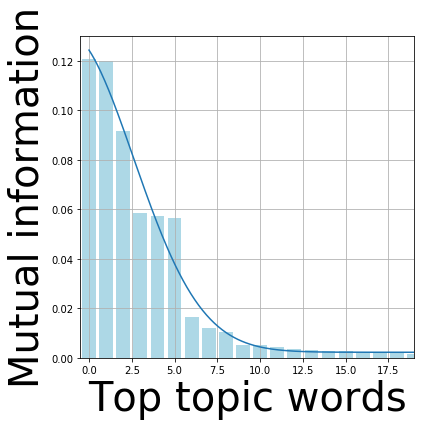

In [187]:
# Mutual information
nwords = 20
topic_words, proba = zip(*topic_model.get_topics(topic=2, n_words=nwords))
# Fitting
x = list(range(nwords))
fit = lambda x, A, x0, sigma, offset:  offset+A*np.exp(-((x-x0)/sigma)**2)
popt, pcov = curve_fit(fit, x, proba, p0=[1,0,1,0])


fig, ax = plt.subplots(figsize=(6,6))

ax.bar(x, proba, color="lightblue", zorder=0)

x = np.linspace(min(x),max(x),250)
ax.plot(x, fit(x,*popt))
ax.set_xlabel('Top topic words', fontsize=40)
ax.set_ylabel('Mutual information', fontsize=40)
ax.grid(True)
ax.axis([-.5,19,0,0.13])
plt.tight_layout()
plt.savefig('MIkid.png')
plt.show()

In [63]:
# Word cloud
text = ' '.join(df_l.loc[(df_top.topic == 2) & (df_top.PTC > 8)].values)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

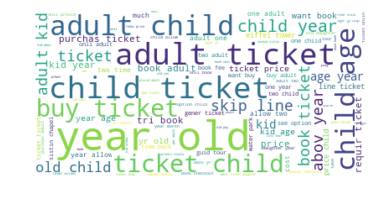

In [65]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('kid1.png', dpi=100)
plt.show()

## Seat

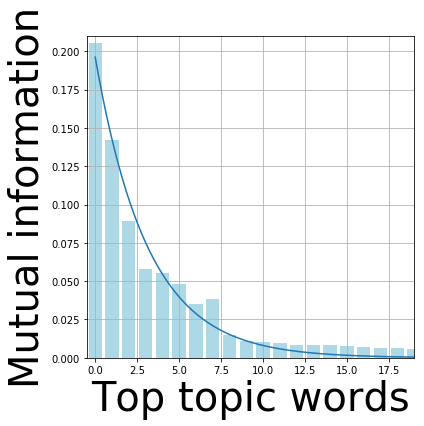

In [183]:
# Mutual information
nwords = 20
topic_words, proba = zip(*topic_model.get_topics(topic=3, n_words=nwords))
# Fitting
x = list(range(nwords))
fit = lambda x, A, sigma:  A*np.exp(-(x/sigma))
popt, pcov = curve_fit(fit, x, proba, p0=[.2,10])


fig, ax = plt.subplots(figsize=(6,6))

ax.bar(x, proba, color="lightblue", zorder=0)

x = np.linspace(min(x),max(x),250)
ax.plot(x, fit(x,*popt))
ax.set_xlabel('Top topic words', fontsize=40)
ax.set_ylabel('Mutual information', fontsize=40)
ax.grid(True)
ax.axis([-.5,19,0,0.21])
plt.tight_layout()
plt.savefig('MIseat.png')
plt.show()

In [119]:
# Word cloud
text = ' '.join(df_l.loc[(df_top.topic == 3) & (df_top.PTC > 8)].values)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

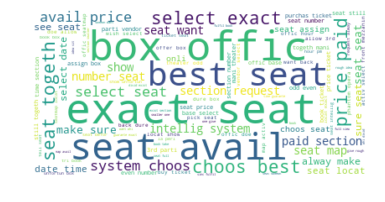

In [121]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('seat2.png', dpi=100)
plt.show()

## Discount

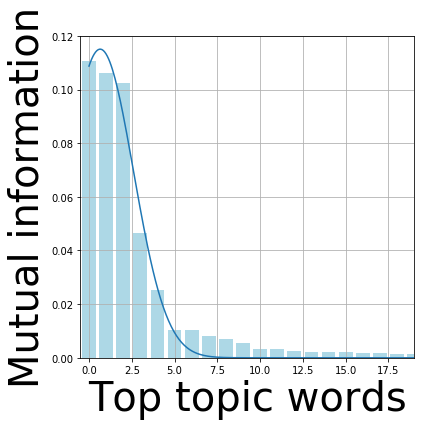

In [186]:
# Mutual information
nwords = 20
topic_words, proba = zip(*topic_model.get_topics(topic=4, n_words=nwords))
# Fitting
x = list(range(nwords))
fit = lambda x, A, x0, sigma:  A*np.exp(-((x-x0)/sigma)**2)
popt, pcov = curve_fit(fit, x, proba, p0=[.2,0,1])


fig, ax = plt.subplots(figsize=(6,6))

ax.bar(x, proba, color="lightblue", zorder=0)

x = np.linspace(min(x),max(x),250)
ax.plot(x, fit(x,*popt))
ax.set_xlabel('Top topic words', fontsize=40)
ax.set_ylabel('Mutual information', fontsize=40)
ax.grid(True)
ax.axis([-.5,19,0,0.12])
plt.tight_layout()
plt.savefig('MIdiscount.png')
plt.show()

In [176]:
text = ' '.join(df_l.loc[(df_top.topic == 4) & (df_top.PTC > 30)].values)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

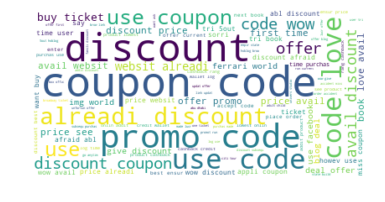

In [178]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('discount.png', dpi=100)
plt.show()

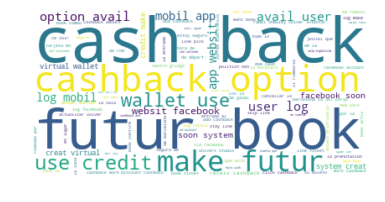

In [189]:
text = ' '.join(df_l.loc[(df_top.topic == 0) & (df_top.PTC > 30)].values)
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()